In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from model import get_default_dual_pipeline_model
from matplotlib import cm

plt.rcParams["font.family"] = "Times New Roman"

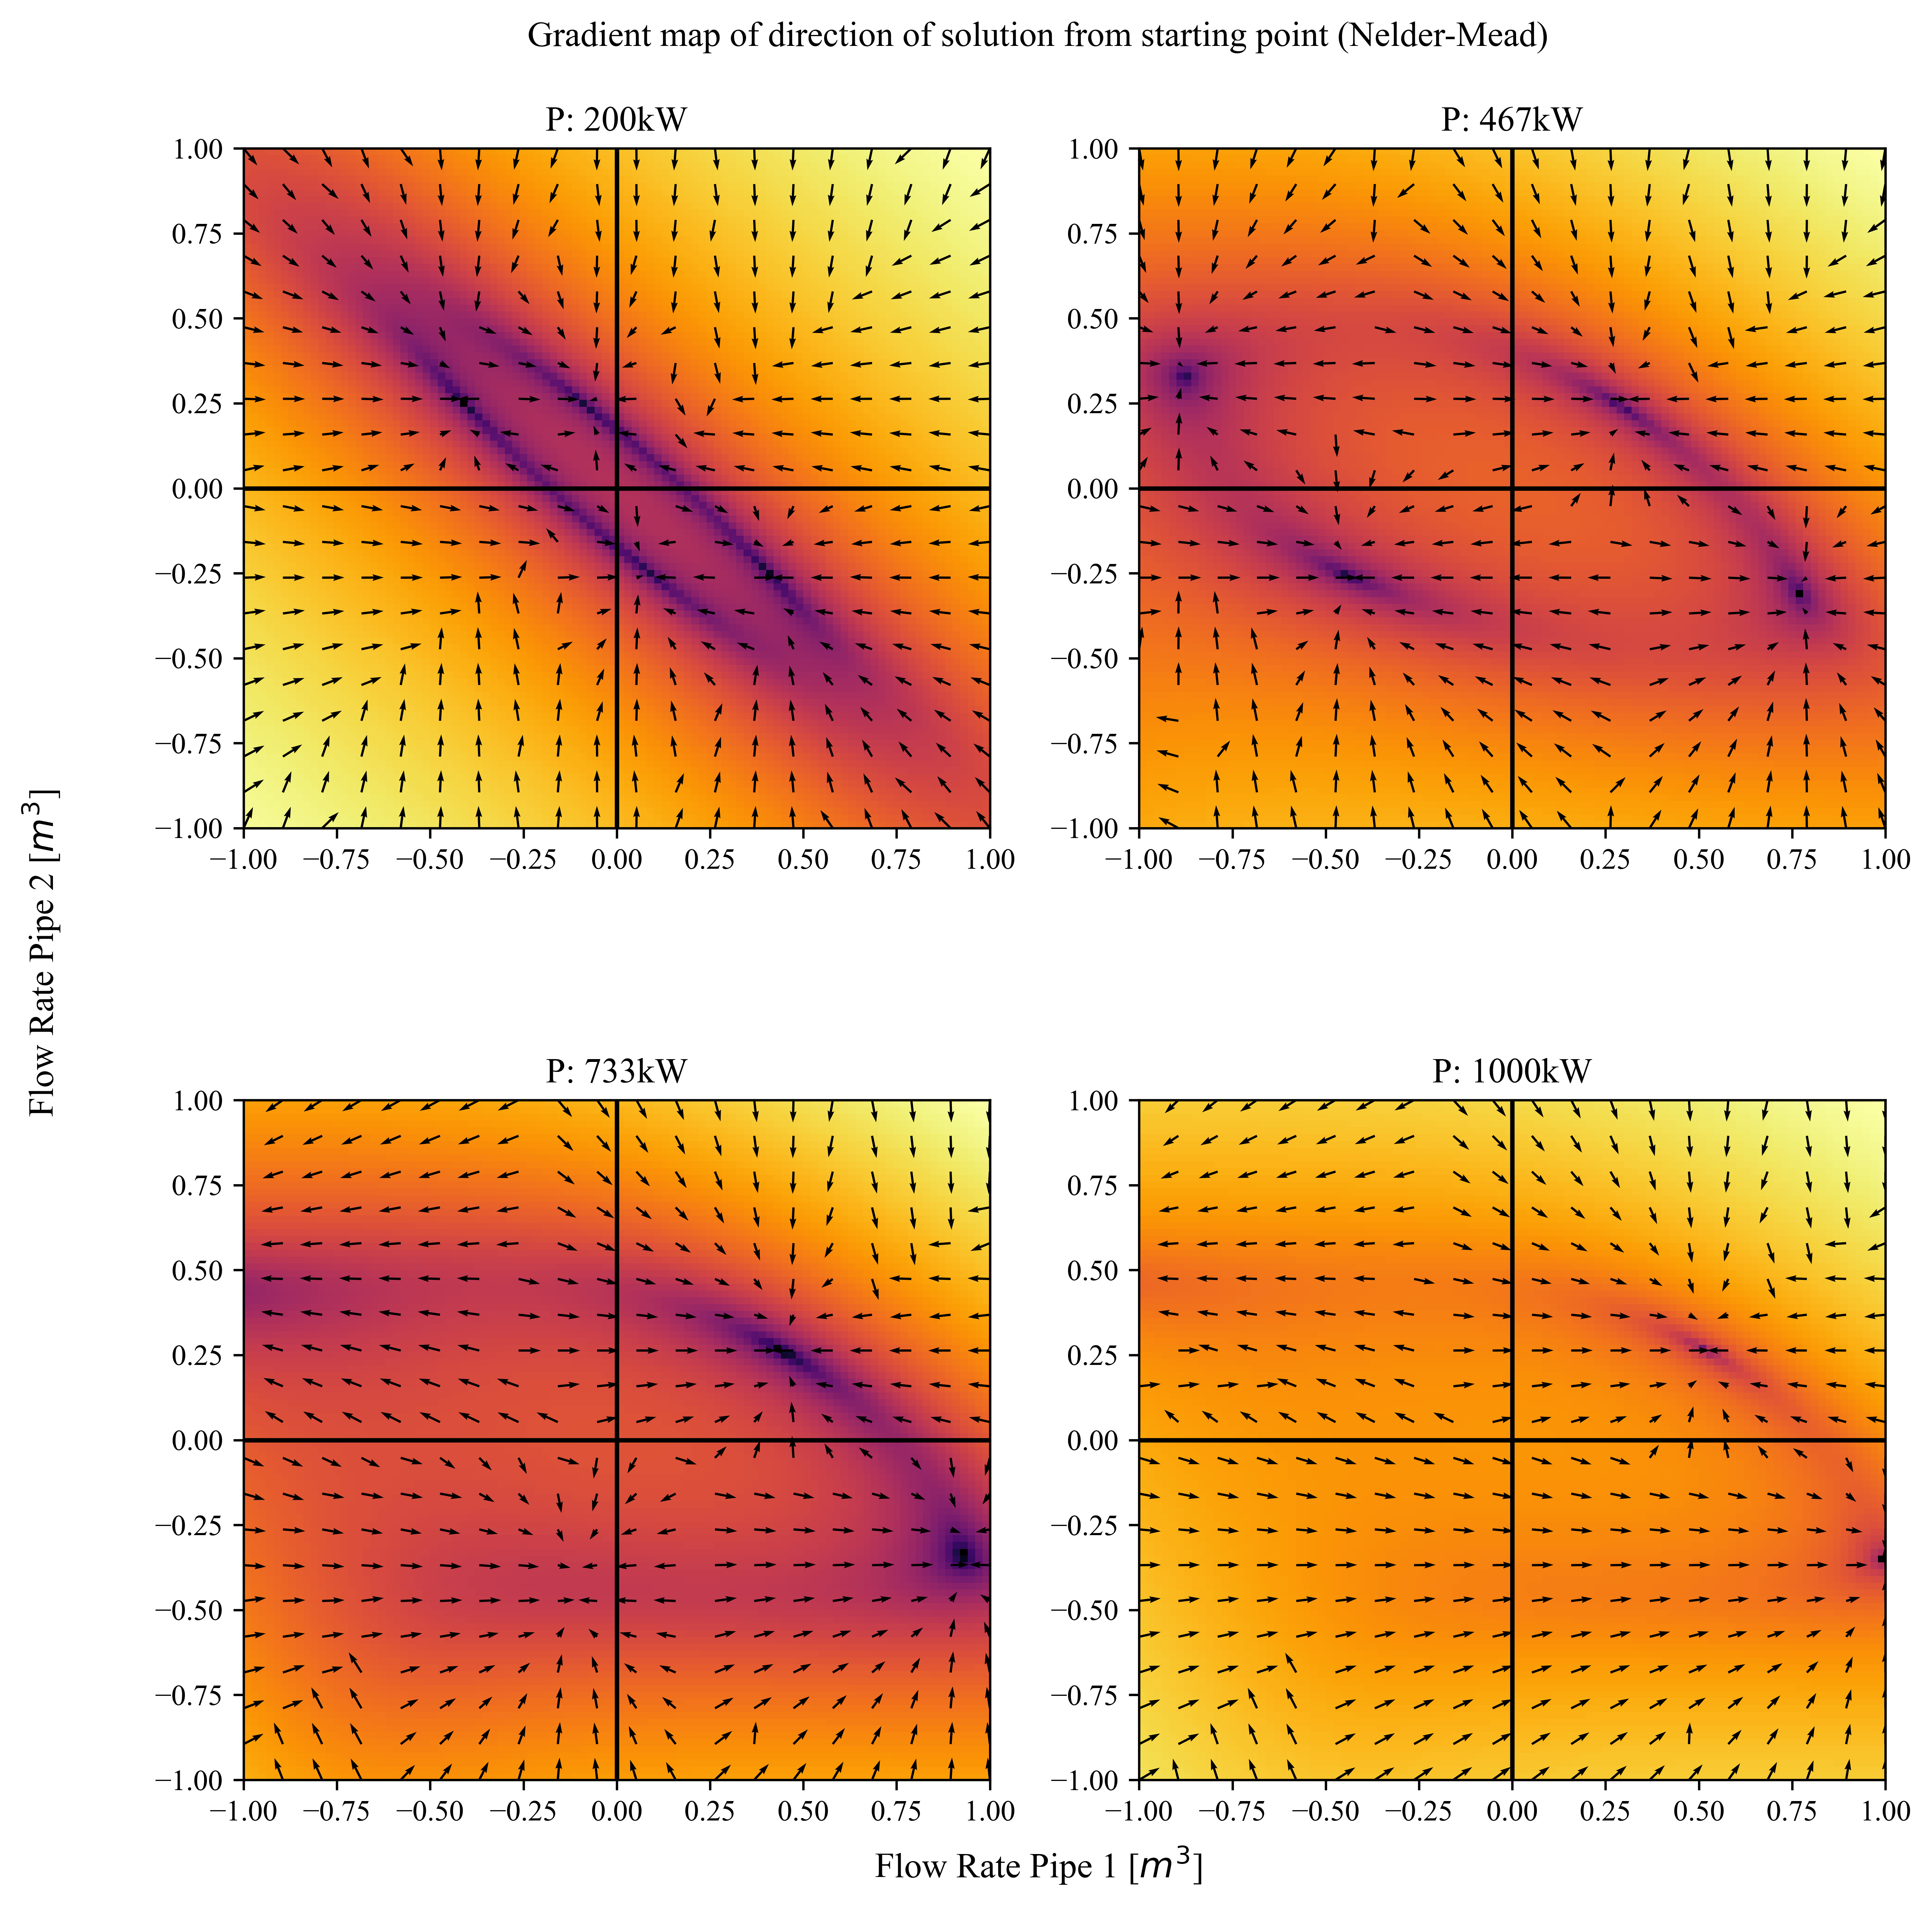

In [4]:
def plot_start_end_quiver(method="Nelder-Mead"):
    model = get_default_dual_pipeline_model()
    
    powers = np.linspace(model.min_power, model.max_power, 4)
    
    fig = plt.figure(figsize=(10, 10), dpi=600)
    gs = fig.add_gridspec(2, 2, hspace=0.4)
    axs = gs.subplots()
    
    for p, power in enumerate(powers):
        model.power = power
        
        flow_rates_pipe1 = np.linspace(-1, 1, 20)
        flow_rates_pipe2 = np.linspace(-1, 1, 20)
        
        x2, y2 = np.meshgrid(flow_rates_pipe1, flow_rates_pipe2)
        starts = np.column_stack((y2.ravel(),x2.ravel()))
        direction = []
        
        flow_rates_pipe1 = np.linspace(-1, 1, 100)
        flow_rates_pipe2 = np.linspace(-1, 1, 100)
        differential_pressures = np.zeros((len(flow_rates_pipe1), len(flow_rates_pipe2)))

        def get_diff_pressure(x, y):
            model.pipelines[0].flow_rate = x
            model.pipelines[1].flow_rate = y
            
            return np.sum(np.power(model.differential_pressures(), 2))

        # calculate pressure for different flow rate and power combinations
        for i, frp1 in enumerate(flow_rates_pipe1):
            for j, frp2 in enumerate(flow_rates_pipe2):
                differential_pressures[j, i] = get_diff_pressure(frp1, frp2)

        for i, pair in enumerate(starts):
            model.pipelines[0].flow_rate = pair[0]
            model.pipelines[1].flow_rate = pair[1]
            model.optimize_flow_rates(method=method)
            u = pair[0] - model.pipelines[0].flow_rate
            v = pair[1] - model.pipelines[1].flow_rate
            
            u = u / np.sqrt(u**2 + v**2)
            v = v / np.sqrt(u**2 + v**2)
            
            direction.append((u, v))
            
        # plot
        i = int(p/2)
        j = p%2
    
        axs[i, j].imshow(differential_pressures/100000, aspect='auto', origin='lower', norm=LogNorm(), cmap=cm.inferno,
                   extent=(min(flow_rates_pipe1), max(flow_rates_pipe1), min(flow_rates_pipe2), max(flow_rates_pipe2)))        
        axs[i, j].quiver(starts[:,0], starts[:,1], [-d[0] for d in direction], [-d[1] for d in direction])
        axs[i, j].axvline(0, color="k")
        axs[i, j].axhline(0, color="k")
        axs[i, j].title.set_text(f"P: {power/1000:.0f}kW")

    fig.suptitle(f"Gradient map of direction of solution from starting point ({method})", y=0.94)
    fig.supxlabel('Flow Rate Pipe 1 [$m^3$]', y=0.06)
    fig.supylabel('Flow Rate Pipe 2 [$m^3$]')
    plt.show()
    
plot_start_end_quiver("Nelder-Mead")